# Objective

Find the best size parameter for the median filter.

# Images used

71 raw images (cropped, not pre-rescaled) were used to find linear transformation parameters. The same images were also used to find blob_dog() intensity thresholds for images with and without bubbles, using `benchmark_blob_dog_find_thresh_w_normxcorr2.ipynb`.

14 new raw images (cropped, not pre-rescaled, 7 with bubbles and 7 without bubbles) are used to determine whether the linear transformation and intensity threshold parameters found using the 71 images

# Preprocessing

normxcorr2 (from https://github.com/czbiohub/cell-counting-imager/blob/828b8af950beb32ff76548f11764c8915bb9b6d6/cell_counting_imager/normxcorr2.py)

Testing: median filter (from https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html)

# Results

Median filter sizes 1 through 5 all have very close r^2 values. Odd number sizes perform better than even. The best median filter sizes are 1 (that is, no median filter at all) and 3.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from normxcorr2 import normxcorr2
from skimage.feature import blob_dog
from skimage.io import imread
from skimage import exposure, transform
from scipy.stats import linregress
from scipy import ndimage
from matplotlib.lines import Line2D
import warnings, math
warnings.filterwarnings('ignore')

In [2]:
def cross_correlate(im):
    im_normxcorr2 = normxcorr2(kernel, im)
    lr_edge = (im_normxcorr2.shape[0] - im.shape[0])/2
    ud_edge = (im_normxcorr2.shape[1] - im.shape[1])/2
    return im_normxcorr2[int(ud_edge):int(ud_edge*-1), int(ud_edge):int(ud_edge*-1)]

In [6]:
names_raw = pd.read_csv('names.csv', header=None)
names = [x[0][23:-4] for x in names_raw.values]

In [3]:
# using default kernel params
kernelSize = 150
ds = 2 # down-sampling integer factor along each axis
discRadius = 3

In [4]:
# set up kernel
kernel = np.zeros((kernelSize, kernelSize), 'uint16')
kernelCtr = kernelSize/2
for rr in range(0, kernelSize + 1):
    for cc in range(0, kernelSize + 1):
        if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < discRadius:
            kernel[rr, cc] = 65535
kernel = transform.downscale_local_mean(kernel, (ds,ds))

## Visual effects of normxcorr and median + normxcorr filters

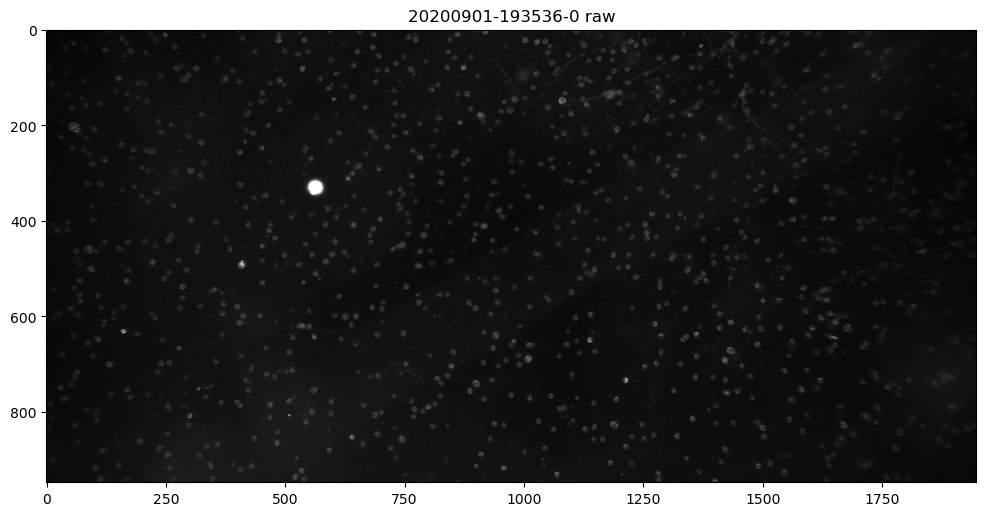

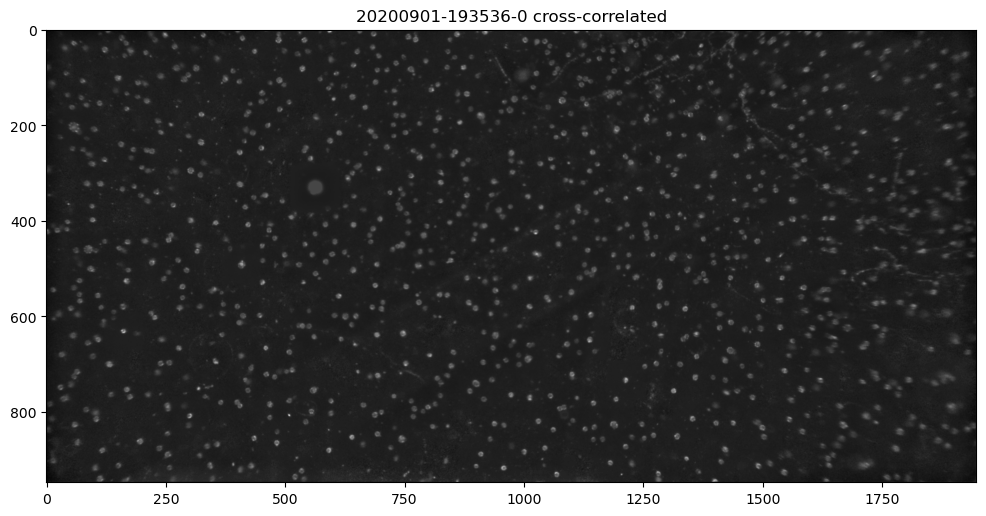

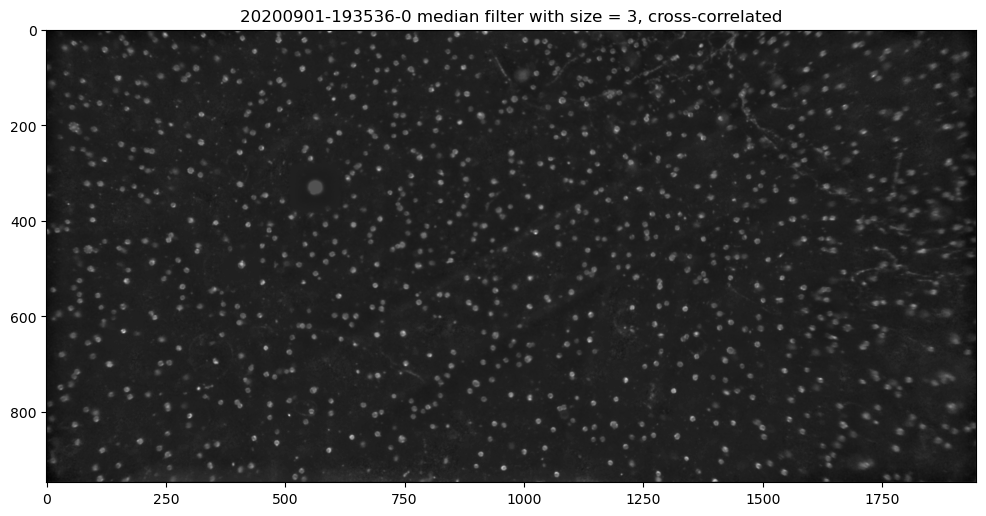

In [7]:
im = imread('raw_images_cropped/image-cropped-%s.tif' % names[0])
im_normxcorr2 = cross_correlate(im)
im_med = ndimage.median_filter(im_normxcorr2, size=3)

plt.figure(figsize=(12,6), dpi=100)
plt.imshow(im, cmap='gray')
plt.title(names[0] + ' raw')
plt.show()

plt.figure(figsize=(12,6), dpi=100)
plt.imshow(im_normxcorr2, cmap='gray')
plt.title(names[0] + ' cross-correlated')
plt.show()

plt.figure(figsize=(12,6), dpi=100)
plt.imshow(im_med, cmap='gray')
plt.title(names[0] + ' median filter with size = 3, cross-correlated')
plt.show()

# Find the best size parameter for the median filter

Use the original 71 test images

In [119]:
data = pd.DataFrame(columns=['name', 'med_filter_size', 'pred', 'pred_med',
                           'gt', 'pred_over_gt', 'pred_med_over_gt'])
for name_ind in range(len(names)):
    print(name_ind, '/', len(names))
    name = names[name_ind]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im_normxcorr2 = cross_correlate(im)
    blobs = blob_dog(im_normxcorr2, min_sigma=5, max_sigma=15, threshold=0.1)
    df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    pred = len(blobs)
    gt = len(df)
    pred_over_gt = len(blobs)/len(df)
    for med_filter_size in np.arange(1,10):
        im_med = ndimage.median_filter(im_normxcorr2, size=med_filter_size)
        blobs_med = blob_dog(im_med, min_sigma=5, max_sigma=15, threshold=0.1)
        pred_med = len(blobs_med)
        pred_med_over_gt = len(blobs_med)/len(df)
        row = pd.DataFrame({
            'name': [name],
            'med_filter_size': [med_filter_size],
            'pred': [pred],
            'pred_med': [pred_med],
            'gt': [gt],
            'pred_over_gt': [pred_over_gt],
            'pred_med_over_gt': [pred_med_over_gt]
        })
        data = data.append(row)

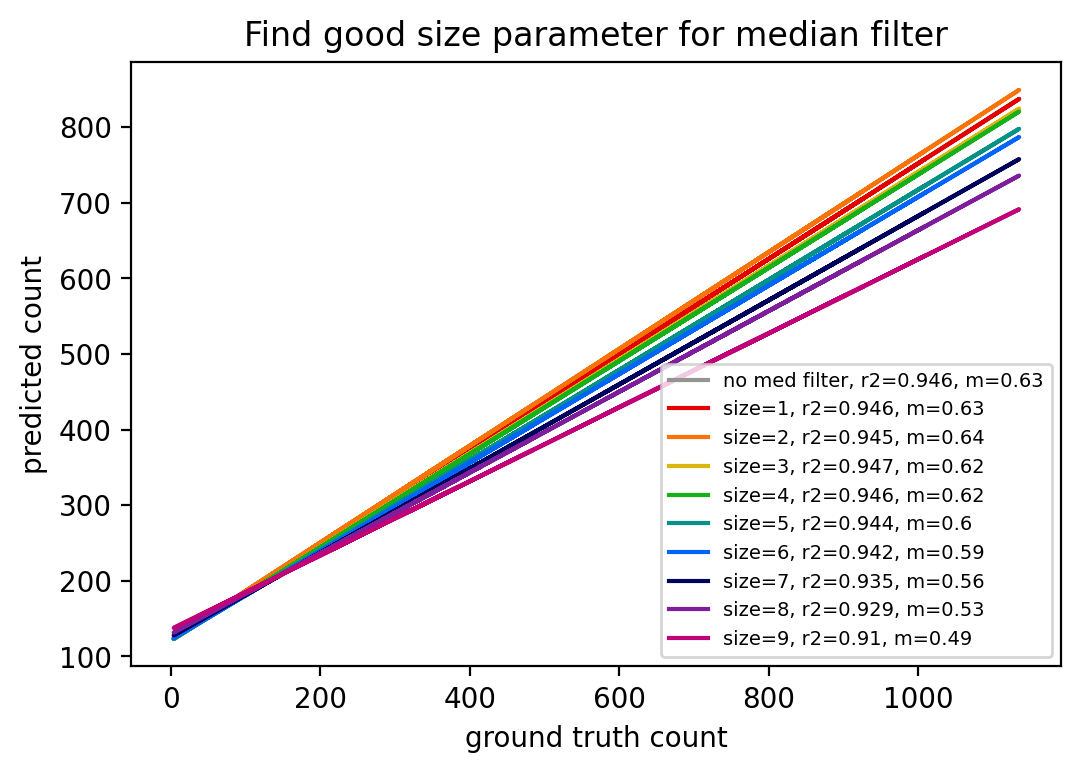

In [126]:
plt.figure(dpi=200)
handles, labels = [], []

data_size = data[data.med_filter_size==1]
gt_counts = list(data_size['gt'])
pred_counts = list(data_size['pred'])
slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
p = plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
handles.append(p)
labels.append('no med filter, r2=%s, m=%s' % (str(round(r_value**2, 3)),
                                              str(round(slope, 2))))

for med_filter_size in np.arange(1,10):
    data_size = data[data.med_filter_size==med_filter_size]
    gt_counts = list(data_size['gt'])
    pred_counts = list(data_size['pred_med'])
    slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
    p = plt.plot(gt_counts, intercept + [slope*x for x in gt_counts],
             color=colors[med_filter_size-1])
    handles.append(p)
    labels.append('size=%s, r2=%s, m=%s' % (str(med_filter_size),
                                            str(round(r_value**2,3)),
                                            str(round(slope,2))))
plt.xlabel('ground truth count')
plt.ylabel('predicted count')
plt.title('Find good size parameter for median filter')
plt.legend(handles, loc='lower right', labels=labels, fontsize=7)
plt.show()